In [1]:
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt

In [2]:
# Initialize SAM model once to avoid reloading in each worker
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint="./sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

c:\Users\dave-\anaconda3\envs\MoIm\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [7]:
def get_identifier(filename: str) -> str:
    """
    Extracts a unique identifier from a filename using a regular expression pattern.
    
    Args:
        filename (str): The filename of the image (e.g., 'A1_03_1_1_Phase Contrast_001.tif').
    
    Returns:
        str: A unique identifier based on the first two parts and last three digits of the filename.
             If the filename does not match the expected pattern, returns None.
    
    Example:
        For a filename "A1_03_1_1_Phase Contrast_001.tif", the function returns "A1_03_001".
    """
    match = re.match(r"^([A-D]\d+_\d+).*_(\d{3})\.tif$", filename)
    return f"{match.group(1)}_{match.group(2)}" if match else None

In [9]:
def plot_masks_in_grid(masks):
    """
    Displays up to 20 SAM-generated masks in a 2x10 grid.

    Args:
        masks (list of np.array): List of binary masks generated by SAM.

    Returns:
        None. Displays the first 20 masks in a 2x10 grid.
    """
    fig, axes = plt.subplots(2, 10, figsize=(20, 6))
    fig.suptitle("Refined SAM Masks within Fish Region", fontsize=16)
    
    for idx, mask in enumerate(masks[:20]):
        mask_display = mask * 255  # Convert to displayable format
        row, col = divmod(idx, 10)
        axes[row, col].imshow(mask_display, cmap="gray")
        axes[row, col].set_title(f"Mask {idx + 1}")
        axes[row, col].axis("off")

    for j in range(len(masks), 20):
        row, col = divmod(j, 10)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Main function to process images
def process_images(input_dir: str, output_dir: str, save_masks: bool = False, save_masked_images: bool = False, show_grid: bool = True) -> pd.DataFrame:
    phase_mask_dir = os.path.join(output_dir, "phase_masks")
    if save_masks:
        os.makedirs(phase_mask_dir, exist_ok=True)

    phase_contrast_files = {}
    gfp_files = {}

    for file_name in os.listdir(input_dir):
        if file_name.endswith(".tif"):
            identifier = get_identifier(file_name)
            if identifier:
                if "Phase Contrast" in file_name:
                    phase_contrast_files[identifier] = os.path.join(input_dir, file_name)
                elif "GFP" in file_name:
                    gfp_files[identifier] = os.path.join(input_dir, file_name)

    gfp_intensity_results = []

    for i, (identifier, phase_path) in enumerate(phase_contrast_files.items()):
        if identifier in gfp_files:
            try:
                gfp_path = gfp_files[identifier]
                phase_image = Image.open(phase_path)
                phase_np = np.array(phase_image, dtype=np.uint16)
                phase_np = (phase_np / phase_np.max() * 255).astype(np.uint8)
                phase_rgb = np.stack([phase_np] * 3, axis=-1)
                predictor.set_image(phase_rgb)

                # Initial segmentation to get the primary mask
                input_point = np.array([[phase_rgb.shape[1] // 2, phase_rgb.shape[0] // 2]])
                input_label = np.array([1])
                primary_masks, _, _ = predictor.predict(
                    point_coords=input_point,
                    point_labels=input_label,
                    multimask_output=False
                )
                primary_mask = primary_masks[0]  # Select the main mask for the fish

                # Apply primary mask to isolate the fish region
                masked_phase_image = phase_np * primary_mask

                # Convert masked_phase_image to RGB format for compatibility with SAM
                masked_phase_rgb = np.stack([masked_phase_image] * 3, axis=-1)

                # Run automatic mask generator on the isolated fish region
                auto_masks = mask_generator.generate(masked_phase_rgb)

                # Extract binary masks from the automatic mask generator output
                refined_masks = [mask['segmentation'] for mask in auto_masks]

                # Show refined masks in a grid if enabled
                if show_grid:
                    plot_masks_in_grid(refined_masks)

                # Load GFP image and apply the primary mask
                gfp_image = Image.open(gfp_path)
                gfp_np = np.array(gfp_image, dtype=np.uint16)
                gfp_values_within_fish = gfp_np[primary_mask > 0]
                mean_gfp_intensity = gfp_values_within_fish.mean() if gfp_values_within_fish.size > 0 else 0
                total_gfp_intensity = gfp_values_within_fish.sum()

                if save_masked_images:
                    gfp_masked = gfp_np * primary_mask
                    output_path = os.path.join(output_dir, f"masked_{identifier}.png")
                    Image.fromarray(gfp_masked.astype(np.uint16)).save(output_path)

                gfp_intensity_results.append({
                    "Identifier": identifier,
                    "Mean_GFP_Intensity": mean_gfp_intensity,
                    "Total_GFP_Intensity": total_gfp_intensity
                })

            except Exception as e:
                print(f"Error processing {identifier}: {e}")

        if (i + 1) % 5 == 0:
            print(f"Processed {i + 1}/{len(phase_contrast_files)} image pairs.")

    results_df = pd.DataFrame(gfp_intensity_results)
    csv_output_path = os.path.join(output_dir, "gfp_intensity_results.csv")
    results_df.to_csv(csv_output_path, index=False)
    
    print(f"Results saved to {csv_output_path}")
    return results_df

In [10]:
# Define paths for loading and saving images
input_dir = r"C:\Users\dave-\OneDrive - ZHAW\HS24\MoIm\MolecularIMaging\Images\test_images"
output_dir = r"C:\Users\dave-\OneDrive - ZHAW\HS24\MoIm\MolecularIMaging\Images\Output"
phase_mask_dir = os.path.join(output_dir, "phase_masks")
os.makedirs(output_dir, exist_ok=True)

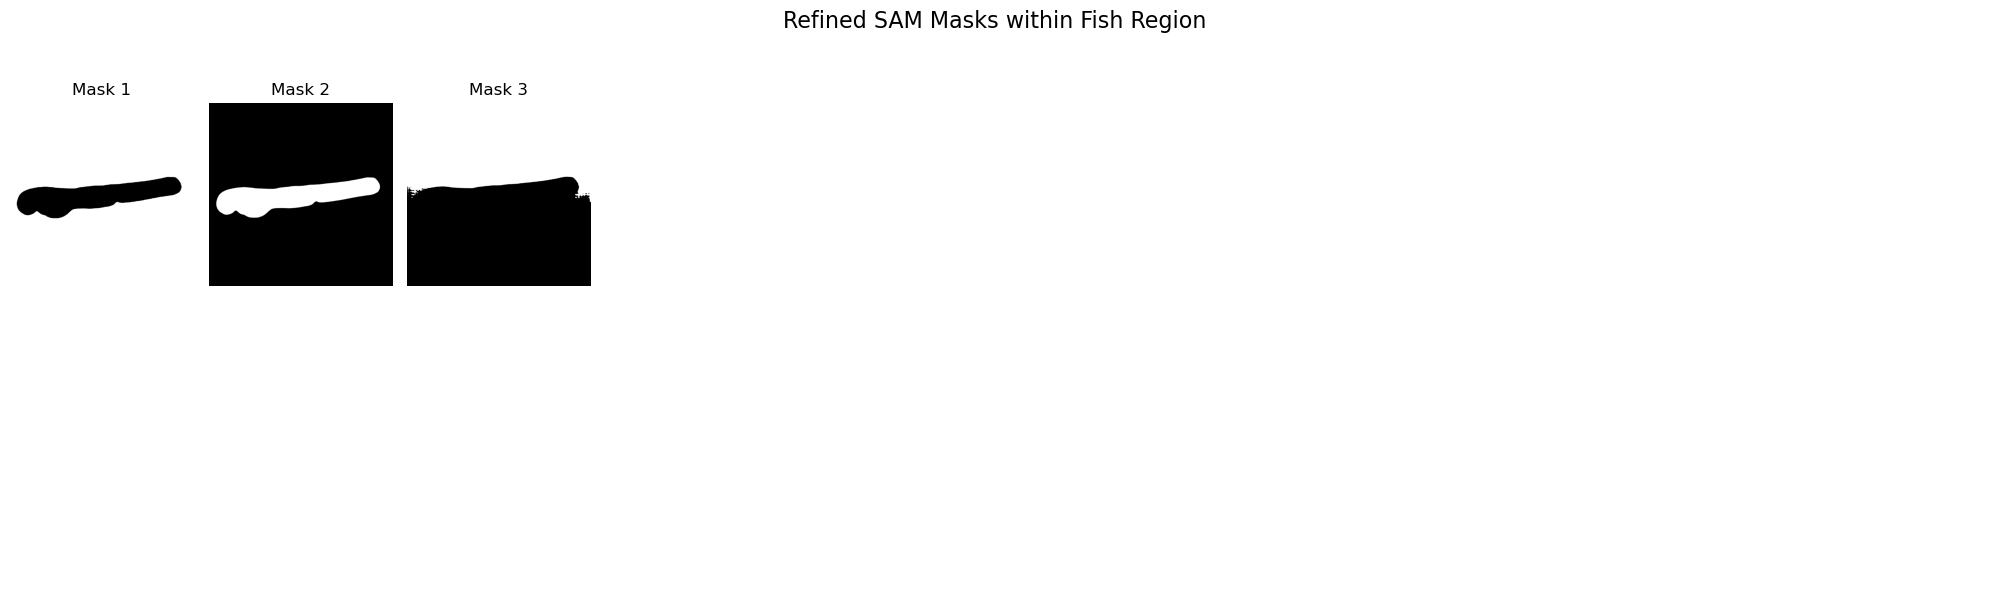

KeyboardInterrupt: 

In [11]:
results_df = process_images(input_dir, 
                            output_dir, 
                            save_masks=True, 
                            save_masked_images=True, 
                            show_grid=True)